In [1]:
#!pip install git+https://github.com/napulen/AugmentedNet/tree/main/rawdata/corrections/BPS

In [2]:
import music21
import mido
from mido import MidiFile
import mirdata
import os
import sys
import py_midicsv as pm
import glob
import csv
import json
import librosa
import pretty_midi
from libfmp import *
import pickle
import mir_eval
import matplotlib.pyplot as plt
import pandas as pd
from unidecode import unidecode
from vampy import *
!pip install py-midi

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.spatial.distance import cosine, euclidean
np.seterr(all='raise')


#TIV
class TonalIntervalVector:
    weights_symbolic = [2, 11, 17, 16, 19, 7]
    weights_audio = [3, 8, 11.5, 15, 14.5, 7.5]

    def __init__(self, energy, vector):
        self.energy = energy
        self.vector = vector
    
    def abs_vector(self):
        return np.abs(self.vector)
    
    def phases_vector(self):
        return np.angle(self.vector)
    
    def get_vector(self):
        return np.array(self.vector)

    def diss(self): #Compute dissonance
        return 1 - (np.linalg.norm(self.vector) / np.sqrt(np.sum(np.dot(self.weights_symbolic, self.weights_symbolic))))

    def coeffs(self, coef): #Compute coefficient
        return self.abs_vector()[coef] / self.weights_symbolic[coef]

    def chromaticity(self): #Compute chromaticity
        return self.abs_vector()[0] / self.weights_symbolic[0]

    def dyads(self): #Compute dyadicity
        return self.abs_vector()[1] / self.weights_symbolic[1]

    def triads(self): #Compute triadicity (triads)
        return self.abs_vector()[2] / self.weights_symbolic[2]

    def d_q(self): #Refers a possible diminished quality
        return self.abs_vector()[3] / self.weights_symbolic[3]

    def diatonal(self): #Compute diatonicity
        return self.abs_vector()[4] / self.weights_symbolic[4]

    def tone(self): #Define wholetoneness
        return self.abs_vector()[5] / self.weights_symbolic[5]
    
    # @classmethod
    # def from_pcp(cls, pcp):
    #     """
    #     Get TIVs from pcp, as the original method
    #     :param pcp: 12xN vector containing N pcps
    #     :return: TIVCollection object
    #     """
    #     if pcp.shape[0] != 12:
    #         raise TypeError("Vector is not compatible with PCP")
    #     fft = np.fft.rfft(pcp, n=12, axis=0)
    #     if fft.ndim == 1:
    #         fft = fft[:, np.newaxis]
    #     energy = fft[0, :] + epsilon
    #     vector = fft[1:7, :]
    #     vector = ((vector / energy) * np.array(cls.weights)[:, np.newaxis])
    #     return cls([TIV(energy[i], vector[:, i]) for i in range(len(energy))])
    
    @classmethod
    def from_pcp(cls, pcp, symbolic=True):
        #      Get TIVs from pcp, as the original method
        #     :param pcp: 12xN vector containing N pcps
        #     :return: TIVCollection object
        #     """
        if pcp.shape[0] == 12:
            fft = np.fft.rfft(pcp, n=12)
            energy = fft[0]
            vector = fft[1:7]
            if symbolic:
                vector = ((vector / energy) * cls.weights_symbolic)
            else:
                vector = ((vector / energy) * cls.weights_audio)           
            return cls(energy, vector)
        else:
            return cls(complex(0), np.array([0, 0, 0, 0, 0, 0]).astype(complex))   

    def plot_TIV(self):
        titles = ["m2/M7", "TT", "M3/m6", "m3/M6", "P4/P5", "M2/m7"]
        TIVector = self.vector / self.weights_symbolic
        i = 1
        for tiv in TIVector:
            circle = plt.Circle((0, 0), 1, fill=False)
            plt.subplot(2, 3, i)
            plt.subplots_adjust(hspace=0.4)
            plt.gca().add_patch(circle)
            plt.title(titles[i - 1])
            plt.scatter(tiv.real, tiv.imag)
            plt.xlim((-1.5, 1.5))
            plt.ylim((-1.5, 1.5))
            plt.grid()
            i = i + 1
        plt.show()
        
    def hchange(self):
        tiv_array = self.vector
        results = []
        for i in range(len(tiv_array)):
            distance = TonalIntervalVector.euclidean(tiv_array[i + 1], tiv_array[i])
            results.append(distance)
        return results

    @classmethod
    def euclidean(cls, tiv1, tiv2):
        return np.linalg.norm(tiv1.vector - tiv2.vector)

    @classmethod
    def cosine(cls, tiv1, tiv2):
        a = np.concatenate((tiv1.vector.real, tiv1.vector.imag), axis=0)
        b = np.concatenate((tiv2.vector.real, tiv2.vector.imag), axis=0)
        if all_zero(a) or all_zero(b):
            distance_computed = euclidean(a, b)
        else:
            distance_computed = cosine(a, b)
        return distance_computed

In [4]:
#Now we will need to take information from TIV. So we will need some additional functions
def all_zero(vector):
    for element in vector:
        if element != 0:
            return False
    return True 

def real_imag(TIVector):
    aux = []
    for i in range(0, TIVector.shape[1]):
        real_vector = []
        imag_vector = []
        for j in range(0, TIVector.shape[0]):
            real_vector.append(TIVector[j][i].real)
            imag_vector.append(TIVector[j][i].imag)
        aux.append(real_vector)
        aux.append(imag_vector)
    return np.array(aux)

def tonalIntervalSpace(chroma, symbolic=True):
    centroid_vector = []
    for i in range(0, chroma.shape[1]):
        each_chroma = [chroma[j][i] for j in range(0, chroma.shape[0])]
        # print(each_chroma)
        if all_zero(each_chroma):
            centroid = [0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j]
        else:
            tonal = TonalIntervalVector.from_pcp(each_chroma, symbolic)
            centroid = tonal.get_vector()
        centroid_vector.append(centroid)
    return real_imag(np.array(centroid_vector))

In [8]:
path_score = 'C:/Users/HP/Downloads/Codigos_Tese/Codigo_ZeMacedo/AugmentedNet/rawdata/corrections/BPS'

def music21_converterScoreMidi(path_info):
    for file in os.listdir(path_info):
        for file in glob.glob("*.mxl"):
        #if file.endswith(".mxl"):
            sc = stream.Stream(file)
            mf = midi.translate.streamToMidiFile(sc)
            #fp = sc.write('midi', fp=files)
            mf.show('midi')
            
            return mf
    
music21_converterScoreMidi(path_score)

files = os.listdir(path_score)
midi_matrix = []
for file in files:
     if file.endswith('mid'):
        midi_matrix.append(file)

midi_matrix

['bps_02_01.mid',
 'bps_03_01.mid',
 'bps_06_01.mid',
 'bps_07_01.mid',
 'bps_08_01.mid',
 'bps_09_01.mid',
 'bps_10_01.mid',
 'bps_11_01.mid',
 'bps_12_01.mid',
 'bps_13_01.mid',
 'bps_14_01.mid',
 'bps_15_01.mid',
 'bps_16_01.mid',
 'bps_17_01.mid',
 'bps_19_01.mid',
 'bps_21_01.mid',
 'bps_23_01.mid',
 'bps_24_01.mid',
 'bps_25_01.mid',
 'bps_26_01.mid',
 'bps_29_01.mid',
 'bps_30_01.mid',
 'bps_31_01.mid',
 'bps_32_01.mid']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

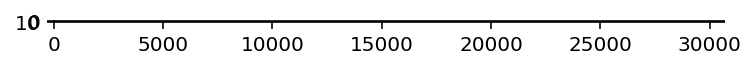

In [9]:
def get_chroma(midi_vector):
    chroma_vector = []
    chroma_bins = []
    file_list = glob.glob(path_score + '/*.mid', recursive=True)
    for file in file_list:
        midi_object = pretty_midi.PrettyMIDI(file)
        chroma_vector = np.zeros((len(midi_object.instruments),12))
        midi_object.time_signature_changes
        midi_object.get_beats()[0:1000]
        midi_object.instruments[0].notes[0:1000]
        
        #midifile = midi_to_list(midi_object)
        #chroma = libfmp.b.b_sonification.list_to_chromagram(file)
        #chromagram = libfmp.b.b_plot.plot_chromagram(chroma)
        
        chromagram = midi_object.get_chroma()
        plt.imshow(chromagram)

        for c in chroma_vector:
            chroma_bins.append(c['Chroma values'].tolist())
    
    #for i, midi_object in enumerate(midi_vector):
    #    for j, element in enumerate(midi_object):
    #        chroma_vector[i][j % 12] += element
                
    return np.array(chroma_vector).transpose()

chroma_list = get_chroma(midi_matrix)
        

In [10]:
def gaussian_blur(centroid_vector, sigma):
    centroid_vector = gaussian_filter(centroid_vector, sigma=sigma)
    return centroid_vector

def get_peaks_hcdf(hcdf_function, rate_centroids_second, symbolic=True):
    changes = [0]
    hcdf_changes = []
    last = 0
    for i in range(2, hcdf_function.shape[0] - 1):
        if hcdf_function[i - 1] < hcdf_function[i] and hcdf_function[i + 1] < hcdf_function[i]:
            hcdf_changes.append(hcdf_function[i])
            if not symbolic:
                changes.append(i / rate_centroids_second)
            else:
                changes.append(i)
            last = i
    return np.array(changes), np.array(hcdf_changes)

#4 - Distance Calculation (Euclidean and Cosine)
def distance_calc(centroid_point, distance):
    dist = []
    if distance == 'Euclidean':
        for j in range(1, centroid_point.shape[1] - 1):
            aux = 0
            for i in range(0, centroid_point.shape[0]):
                aux += ((centroid_point[i][j + 1] - centroid_point[i][j - 1]) ** 2)
            aux = np.math.sqrt(aux)
            dist.append(aux)
    
    if distance == 'Cosine':
        for j in range(1, centroid_point.shape[1] - 1):
            cosine_distance = cosine(centroid_point[:, j - 1], centroid_point[:, j + 1])
            dist.append(cosine_distance)
    dist.append(0)

    return np.array(dist)

def harmonic_change(chroma: list, window_size: int=2048, symbolic: bool=True, 
                         sigma: int = 5, dist: str = 'euclidean'):
    chroma = np.array(chroma).transpose()
    centroid_vector = tonalIntervalSpace(chroma, symbolic=symbolic)

    # blur
    centroid_vector_blurred = gaussian_blur(centroid_vector, sigma)

    # harmonic distance and calculate peaks
    harmonic_function = distance_calc(centroid_vector_blurred, dist)

    changes, hcdf_changes = get_peaks_hcdf(harmonic_function, window_size, symbolic)

    return changes, hcdf_changes, harmonic_function

In [11]:
changes, hcdf_changes, harmonic_function = harmonic_change(chroma=chroma_list, symbolic=True, sigma=28, dist='euclidean')
changes

changes_ground_truth = np.array([m['time'] for m in midi_matrix])
changes_ground_truth

f_measure, precision, recall = mir_eval.onset.f_measure(changes_ground_truth, changes, window=31.218) #same window than Harte
f_measure, precision, recall

NameError: name 'chroma_list' is not defined

Evaluate_HCDFunction_in_BPS_Dataset 30 euclidean


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

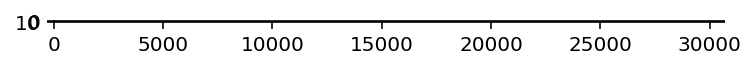

In [12]:
"""# HCDF evaluation across the haydn op20 dataset"""

def evaluate_HCDFunction_in_BPS_Dataset(sigma=30, distance='euclidean'):
    f_measure_results = []
    precision_results = []
    recall_results = []
    print("Evaluate_HCDFunction_in_BPS_Dataset", sigma, distance)
    for file in midi_matrix:
        chroma_list = get_chroma(midi_matrix)
        
        changes, hcdf_changes, harmonic_function = harmonic_change(chroma=chroma_list, symbolic=True, sigma=28, dist='euclidean')

        changes_ground_truth = np.array([m['time'] for m in midi_matrix])

        f_measure, precision, recall = mir_eval.onset.f_measure(changes_ground_truth, changes, window=31.218) #same window than Harte
        f_measure_results.append(f_measure)
        precision_results.append(precision)
        recall_results.append(recall)
    return np.mean(np.array(f_measure_results)), np.mean(np.array(precision_results)), np.mean(np.array(recall_results))

evaluate_HCDFunction_in_BPS_Dataset()

results_euclidean = {
    sigma: evaluate_HCDFunction_in_BPS_Dataset(sigma=sigma, distance='euclidean') 
    for sigma in range(1, 52, 5)
}

def tune_sigma_plot(evaluation_result):
    sigma_list = []; type_metric = []; metrics = []
    for s, v in evaluation_result.items():
        f, p, r = v
        # f measure
        sigma_list.append(s)
        type_metric.append("F_score")
        metrics.append(f)
        # Precision
        sigma_list.append(s)
        type_metric.append("Precision")
        metrics.append(p)
        # Recall
        sigma_list.append(s)
        type_metric.append("Recall")
        metrics.append(r)
    df_dict = {
        "sigma": sigma_list,
        "metric": type_metric,
        "value": metrics
    }

    df = pd.DataFrame(df_dict)
    fig = px.line(df, x="sigma", y="value", color="metric", render_mode="svg")
    fig.show()

tune_sigma_plot(results_euclidean)

results_cosine = {
    sigma: evaluate_HCDFunction_in_BPS_Dataset(sigma=sigma, distance='cosine') 
    for sigma in range(1, 52, 5)
}
tune_sigma_plot(results_cosine)
